In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta



In [2]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

spy = spy.iloc[:, :-1]  # Select all rows and all columns except the last one

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

In [3]:
btc = pd.read_excel("../data/pricing_data.xlsx", sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)


In [4]:
tlt = pd.read_excel("../data/pricing_data.xlsx", sheet_name='TLT - iShares 20+ Year Bond')

tlt = tlt.iloc[:, :-1]  # Select all rows and all columns except the last one

# Convert the 'Date' column to datetime format
tlt['Date'] = pd.to_datetime(tlt['Date'])

# Sort by date
tlt = tlt.sort_values(by='Date')

# Reset index if needed
tlt.reset_index(drop=True, inplace=True)


In [ ]:
def generate_signals(df):
    """Generate trading signals based on SMA crossovers"""
    signals = pd.DataFrame(index=df.index)
    signals['price'] = df['Close']

    # SMA crossover signals
    signals['sma5_10'] = np.where(df['SMAVG (5)  on Close'] > df['SMAVG (10)  on Close'], 1, -1)
    signals['sma10_15'] = np.where(df['SMAVG (10)  on Close'] > df['SMAVG (15)  on Close'], 1, -1)

    # Combine signals (range: -2 to +2)
    signals['signal'] = signals['sma5_10'] + signals['sma10_15']

    # Momentum calculation (optional)
    signals['momentum'] = df['Close'].pct_change(5)

    return signals

#An SMA crossover occurs when one SMA crosses above or below another SMA.
# For example:
# If SMAVG (5) > SMAVG (10), it indicates a short-term bullish trend → Signal = 1.
# If SMAVG (5) ≤ SMAVG (10), it indicates a short-term bearish trend → Signal = -1.
# Similarly:
# If SMAVG (10) > SMAVG (15), it indicates a medium-term bullish trend → Signal = 1.
# If SMAVG (10) ≤ SMAVG (15), it indicates a medium-term bearish trend → Signal = -1.

#The two SMA signals are combined into a single signal:
# Possible values for 'signal':
# +2: Strong bullish trend (sma5_10 = 1 and sma10_15 = 1).
# +1: Mild bullish trend (one SMA signal is bullish, the other is neutral or bearish).
# 0: Neutral trend (the two SMA signals cancel each other out).
# -1: Mild bearish trend.
# -2: Strong bearish trend (sma5_10 = -1 and sma10_15 = -1).

# This is better than a simple trend-following strategy because this is more suited for asset rebalancing
# we are not just deciding whether to be in or out (binary result), we're deciding how much to allocate based on conviction.



In [ ]:
def allocation_drift_exceeds(current, target, threshold):
    """
    Check if allocation drift exceeds threshold for any asset.
    """
    return any(abs(current[asset] - target[asset]) > threshold for asset in current)


In [ ]:
# Signal arrives -> Call determine_allocation() → Get your target weights -> Call rebalance_portfolio() → Actually trade toward that target, considering costs -> Continue with updated allocation and portfolio value

def updated_backtest_strategy(start_date, end_date, btc_data, spy_data, tlt_data,
                              initial_capital=1000000, transaction_cost_rate=0.001,
                              rebalance_threshold=0.05):
    """Backtest a four-asset strategy (CASH, BTC, SPY, TLT) with no shorting and static cash value."""

    initial_allocation = {
        'CASH': 0.0280,
        'BTC': 0.1666,
        'SPY': 0.8054,
        'TLT': 0.0000
    }

    current_allocation = initial_allocation.copy()
    current_holdings = {asset: initial_capital * weight for asset, weight in current_allocation.items()}
    portfolio_values = []
    allocations_history = []

    dates = pd.date_range(start=start_date, end=end_date, freq='30min')

    for date in dates:
        is_trading_day = date.weekday() < 5
        is_market_hours = is_trading_day and 9 <= date.hour < 16

        btc_now = btc_data[btc_data['Date'] <= date]
        spy_now = spy_data[spy_data['Date'] <= date]
        tlt_now = tlt_data[tlt_data['Date'] <= date]

        # === Update holdings with returns ===
        if len(btc_now) >= 2:
            ret = btc_now['Close'].iloc[-1] / btc_now['Close'].iloc[-2]
            current_holdings['BTC'] *= ret
        if is_market_hours:
            if len(spy_now) >= 2:
                ret = spy_now['Close'].iloc[-1] / spy_now['Close'].iloc[-2]
                current_holdings['SPY'] *= ret
            if len(tlt_now) >= 2:
                ret = tlt_now['Close'].iloc[-1] / tlt_now['Close'].iloc[-2]
                current_holdings['TLT'] *= ret

        # Portfolio value after returns
        portfolio_value = sum(current_holdings.values())
        portfolio_values.append(portfolio_value)
        allocations_history.append(current_allocation.copy())

        # === Rebalance during market hours ===
        if is_market_hours and not btc_now.empty and not spy_now.empty and not tlt_now.empty:
            if btc_now.shape[0] < 15 or spy_now.shape[0] < 15 or tlt_now.shape[0] < 15:
                continue

            btc_signal = generate_signals(btc_now.tail(15))
            spy_signal = generate_signals(spy_now.tail(15))
            tlt_signal = generate_signals(tlt_now.tail(15))

            new_allocation = determine_allocation(btc_signal, spy_signal, tlt_signal, current_allocation)

            if allocation_drift_exceeds(current_allocation, new_allocation, rebalance_threshold):
                current_allocation, current_holdings = rebalance_portfolio(
                    current_allocation, new_allocation, portfolio_value, current_holdings,
                    transaction_cost_rate, rebalance_threshold
                )

        # === BTC-only off-hour adjustment ===
        elif not is_market_hours and not btc_now.empty:
            if btc_now.shape[0] < 15:
                continue

            btc_signal = generate_signals(btc_now.tail(15))
            new_allocation = handle_btc_off_hours(btc_signal, current_allocation)

            if allocation_drift_exceeds(current_allocation, new_allocation, rebalance_threshold):
                current_allocation, current_holdings = rebalance_portfolio(
                    current_allocation, new_allocation, portfolio_value, current_holdings,
                    transaction_cost_rate, rebalance_threshold
                )

    return pd.Series(portfolio_values, index=dates), pd.DataFrame(allocations_history, index=dates)


In [ ]:
def determine_allocation(btc_signal, spy_signal, tlt_signal, current_allocation): #Decides what your portfolio should look like
    # Start from the actual current allocation instead of equal weights
    new_allocation = current_allocation.copy()

    # Adjust SPY
    if spy_signal['signal'].iloc[-1] == 2:
        new_allocation['SPY'] = min(0.90, new_allocation['SPY'] + 0.05) # Increase SPY allocation by 5%, but don’t go above 90%.
        new_allocation['CASH'] = max(0.0, new_allocation['CASH'] - 0.05) # Fund this change by reducing cash (by the same amount), but ensure cash doesn’t drop below zero.
    elif spy_signal['signal'].iloc[-1] == -2:
        new_allocation['SPY'] = max(0.10, new_allocation['SPY'] - 0.10) # Reduce SPY exposure by 10%, but don’t let it fall below 10%.
        new_allocation['CASH'] = min(1.0, new_allocation['CASH'] + 0.10) # Move freed-up capital to Cash, but don’t let Cash go above 100%.

    # Adjust BTC 
    if btc_signal['signal'].iloc[-1] == 2:
        new_allocation['BTC'] = min(0.30, new_allocation['BTC'] + 0.05) # Increase BTC allocation by 5%, but don’t go above 30%.
        new_allocation['CASH'] = max(0.0, new_allocation['CASH'] - 0.05) # Fund this change by reducing cash (by the same amount), but ensure cash doesn’t drop below zero.
    elif btc_signal['signal'].iloc[-1] == -2:
        new_allocation['BTC'] = max(0.05, new_allocation['BTC'] - 0.05) # Reduce BTC exposure by 5%, but don’t let it fall below 5%.
        new_allocation['CASH'] = min(1.0, new_allocation['CASH'] + 0.05) # Move freed-up capital to Cash, but don’t let Cash go above 100%.

    # Adjust TLT
    if tlt_signal['signal'].iloc[-1] == 2:
        new_allocation['TLT'] = min(0.25, new_allocation['TLT'] + 0.05) # Add exposure, max 25%
        new_allocation['CASH'] = max(0.0, new_allocation['CASH'] - 0.05)
    elif tlt_signal['signal'].iloc[-1] == -2:
        new_allocation['TLT'] = max(0.0, new_allocation['TLT'] - 0.05) # Reduce exposure, min 0%
        new_allocation['CASH'] = min(1.0, new_allocation['CASH'] + 0.05)

    # Bearish case: all signals negative → de-risk
    if all(x['signal'].iloc[-1] < 0 for x in [btc_signal, spy_signal, tlt_signal]):
        new_allocation['CASH'] = max(new_allocation['CASH'], 0.40) # Make sure you’re holding at least 40% in cash
        total_risk = new_allocation['BTC'] + new_allocation['SPY'] + new_allocation['TLT']
        if total_risk > 0:
            factor = (1.0 - new_allocation['CASH']) / total_risk # Figure out what scaling factor is needed to shrink BTC, SPY, and TLT so their sum = 60% (if cash is now 40%).
            new_allocation['BTC'] *= factor # Rescale the risky assets while preserving their relative weights.
            new_allocation['SPY'] *= factor
            new_allocation['TLT'] *= factor

    # Normalize
    total = sum(new_allocation.values()) #Sum up all allocations (in case rounding or edge cases skewed the total).
    for key in new_allocation:
        new_allocation[key] = max(0.0, new_allocation[key] / total) # Normalize all values so they sum to 1 (or 100% of your capital), and ensure no negatives.

    return new_allocation


In [ ]:
def rebalance_portfolio(current_allocation, target_allocation, total_portfolio_value, current_holdings,
                        transaction_cost_rate, rebalance_threshold):
    """
    Rebalance portfolio from current_allocation to target_allocation,
    accounting for transaction costs:
        - 0.03% for SPY and TLT
        - 0.05% for BTC
        - No cost for CASH
    """
    transaction_costs = {
        'BTC': 0.0005,
        'SPY': 0.0003,
        'TLT': 0.0003,
        'CASH': 0.0
    }

    total_cost = 0.0
    adjusted_allocation_value = {}

    # Step 1: Calculate trade amounts and transaction costs
    for asset in current_allocation:
        current_value = current_allocation[asset] * total_portfolio_value
        target_value = target_allocation[asset] * total_portfolio_value
        trade_value = abs(target_value - current_value)
        cost = trade_value * transaction_costs[asset]
        total_cost += cost

    # Step 2: Subtract transaction cost from portfolio value
    net_portfolio_value = total_portfolio_value - total_cost

    # Step 3: Recompute allocation based on target weights and net portfolio
    for asset in target_allocation:
        adjusted_allocation_value[asset] = target_allocation[asset] * net_portfolio_value

    # Step 4: Convert allocation values back to weights
    new_total_value = sum(adjusted_allocation_value.values())
    new_allocation = {asset: value / new_total_value for asset, value in adjusted_allocation_value.items()}

    # Step 5: Update holdings based on the new allocation
    new_holdings = {asset: new_allocation[asset] * net_portfolio_value for asset in new_allocation}

    return new_allocation, new_holdings


In [9]:
def handle_btc_off_hours(btc_signal, current_allocation):
    new_allocation = current_allocation.copy()
    signal = btc_signal['signal'].iloc[-1]

    if signal >= 1:
        new_btc = min(new_allocation['BTC'] + 0.05, 0.35)
        delta = new_btc - new_allocation['BTC']
        new_allocation['BTC'] = new_btc
        new_allocation['CASH'] = max(0.0, new_allocation['CASH'] - delta)
    elif signal <= -1:
        new_btc = max(new_allocation['BTC'] - 0.05, 0.10)
        delta = new_allocation['BTC'] - new_btc
        new_allocation['BTC'] = new_btc
        new_allocation['CASH'] = min(1.0, new_allocation['CASH'] + delta)

    return new_allocation


In [16]:
start_date = "2025-01-01"
end_date = "2025-02-28"

portfolio_values, allocations_history = updated_backtest_strategy(
    start_date=start_date,
    end_date=end_date,
    btc_data=btc,
    spy_data=spy,
    tlt_data=tlt,
    initial_capital=1000000,
    transaction_cost_rate=0.001,
    rebalance_threshold=0.05
)


In [ ]:
def plot_portfolio_performance(portfolio_values):
    """Visualize how the portfolio performed over time"""
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value', color='blue')
    plt.title('Portfolio Performance (Jan–Feb 2025)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


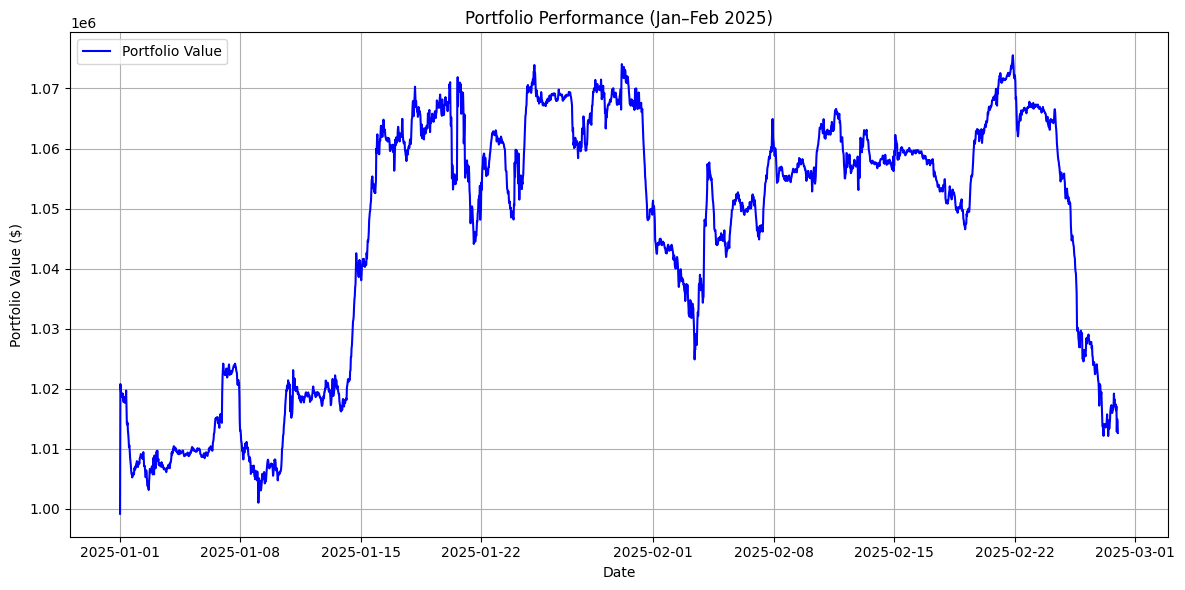

In [17]:
plot_portfolio_performance(portfolio_values)
